# Pendulum

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    \tau
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the pendulum upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0
    \end{bmatrix}
\end{equation*}
$$

**Note**: To deal with angle wrap-around issues, we augment the state as follows:

$$
\begin{equation*}
\hat{\textbf{x}} = \begin{bmatrix}
    \dot{\theta} & \sin{\theta} & \cos{\theta}
    \end{bmatrix}
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by instead fitting
for unconstrained actions and then applying it to a squashing function $\tanh(\textbf{u})$.
This is directly embedded into the dynamics model in order to be auto-differentiated.
This also means that we need to apply this transformation manually to the output of our
controller at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
import numpy as np

In [6]:
DT = 0.05  # Time step (s).
RENDER = True  # Whether to render the environment or not.
CONSTRAIN = True  # Whether to constrain the action space or not.
MIN_BOUNDS = -1.0  # Minimum torque (N m).
MAX_BOUNDS = +1.0  # Maximum torque (N m).
N = 150 if CONSTRAIN else 50  # Horizon length.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.models.utils.encoding.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.pendulum.PendulumCost()
model = pddp.examples.pendulum.PendulumDynamicsModel(DT)
env = pddp.examples.pendulum.PendulumEnv(dt=DT, render=RENDER)

In [8]:
if CONSTRAIN:
    # Constrain the environment and model.
    pddp.models.utils.constraint.constrain_env(env, MIN_BOUNDS, MAX_BOUNDS)
    pddp.models.utils.constraint.constrain_model(model, MIN_BOUNDS, MAX_BOUNDS)

In [9]:
def plot(Z, U):
    t = np.arange(N + 1) * DT
    X = pddp.models.utils.angular.reduce_state(Z, model.angular_indices,
                                               model.non_angular_indices)
    X = X.detach().numpy()
    if CONSTRAIN:
        U = pddp.models.utils.constraint.constrain(U, MIN_BOUNDS, MAX_BOUNDS)
    U = U.detach().numpy()

    theta = np.unwrap(X[:, 0])  # Makes for smoother plots.
    theta_dot = X[:, 1]
    
    plt.figure()
    plt.plot(theta, theta_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Orientation Phase Plot")

    plt.figure()
    plt.plot(t, theta)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Orientation path")

    plt.figure()
    plt.plot(t, theta_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Angular velocity path")
    
    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Torque (N m)")
    plt.title("Constrained action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [10]:
def on_iteration(iteration, Z, U, J_opt, accepted, converged):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    info = "CONVERGED" if converged else ("accepted" if accepted else "FAILED")
    final_state = pddp.models.utils.angular.reduce_state(Z[-1], model.angular_indices,
                                               model.non_angular_indices).detach().numpy()
    print("iteration", iteration + 1, info, J_opt, final_state)

In [11]:
controller = pddp.controllers.PDDPController(env, model, cost)

In [12]:
U = torch.randn(N, model.action_size, requires_grad=True)

In [13]:
J_hist = []
controller.eval()
env.reset()
Z, U = controller.fit(U, encoding=ENCODING, n_iterations=200, on_iteration=on_iteration)

iteration 1 accepted 57699.39 [-3.0513816 -7.43889  ]
iteration 2 accepted 55593.52 [-0.53476757  2.6602702 ]
iteration 3 accepted 55281.965 [-0.79647917  2.5174813 ]
iteration 4 accepted 54073.715 [0.6053    3.2435362]
iteration 5 accepted 47683.105 [0.49376962 3.4699917 ]
iteration 6 accepted 40822.473 [-0.3429164 -2.277261 ]
iteration 7 accepted 40678.055 [-0.19084519 -2.073967  ]
iteration 8 accepted 40605.656 [ 0.1107543 -1.9716235]
iteration 9 FAILED 40605.656 [ 0.1107543 -1.9716235]
iteration 10 FAILED 40605.656 [ 0.1107543 -1.9716235]
iteration 11 FAILED 40605.656 [ 0.1107543 -1.9716235]
iteration 12 FAILED 40605.656 [ 0.1107543 -1.9716235]
iteration 13 FAILED 40605.656 [ 0.1107543 -1.9716235]
iteration 14 FAILED 40605.656 [ 0.1107543 -1.9716235]
iteration 15 FAILED 40605.656 [ 0.1107543 -1.9716235]
iteration 16 accepted 39137.3 [0.7751373 2.34314  ]
iteration 17 accepted 36902.652 [0.5020694 1.4802352]
iteration 18 accepted 36778.496 [-0.1883638 -2.6535919]
iteration 19 accept

iteration 149 accepted 26206.678 [ 0.00442212 -0.00737997]
iteration 150 accepted 26190.281 [0.01086947 0.00134171]
iteration 151 accepted 26147.258 [-0.05131004 -0.07675482]
iteration 152 FAILED 26147.258 [-0.05131004 -0.07675482]
iteration 153 FAILED 26147.258 [-0.05131004 -0.07675482]
iteration 154 FAILED 26147.258 [-0.05131004 -0.07675482]
iteration 155 FAILED 26147.258 [-0.05131004 -0.07675482]
iteration 156 accepted 26136.492 [0.12396293 0.18089174]
iteration 157 accepted 26107.428 [-0.09189381 -0.1848714 ]
iteration 158 FAILED 26107.428 [-0.09189381 -0.1848714 ]
iteration 159 FAILED 26107.428 [-0.09189381 -0.1848714 ]
iteration 160 FAILED 26107.428 [-0.09189381 -0.1848714 ]
iteration 161 accepted 26092.137 [-0.08340652 -0.14298493]
iteration 162 accepted 26078.916 [0.02099442 0.00805119]
iteration 163 FAILED 26078.916 [0.02099442 0.00805119]
iteration 164 accepted 26077.447 [-0.0620579  -0.09267561]
iteration 165 accepted 26056.688 [0.0594569  0.09909436]
iteration 166 accepted 

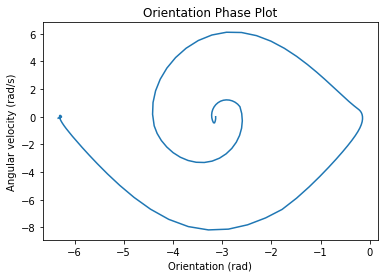

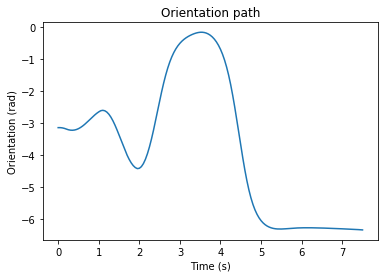

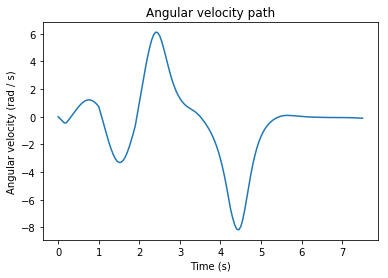

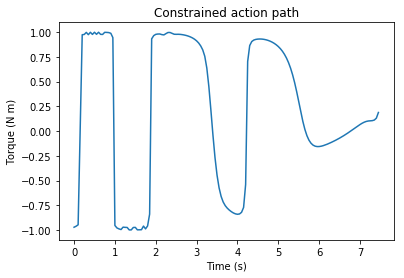

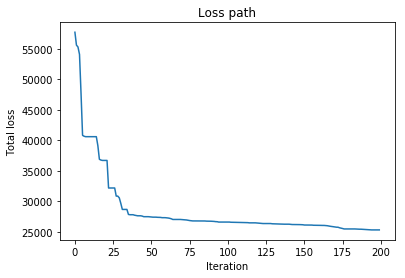

In [14]:
plot(Z, U)

In [15]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [16]:
import time

for i, u in enumerate(U):
    env.apply(u)
    time.sleep(DT)

In [17]:
env.close()